<a href="https://colab.research.google.com/github/sena1bayram/BrainCancer/blob/main/BrainCancer_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
orvile_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/brain-cancer-mri-dataset')

print('Data source import complete.')


Data source import complete.


Veri bölme işlemi tamamlandı.
Found 5592 images belonging to 3 classes.
Found 1681 images belonging to 3 classes.
Found 1689 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.4817 - loss: 0.9915 - val_accuracy: 0.6776 - val_loss: 0.7038
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.6271 - loss: 0.8209 - val_accuracy: 0.7091 - val_loss: 0.6513
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.6522 - loss: 0.7903 - val_accuracy: 0.7287 - val_loss: 0.6294
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.6740 - loss: 0.7382 - val_accuracy: 0.7835 - val_loss: 0.5762
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.6995 - loss: 0.6907 - val_accuracy: 0.7763 - val_loss: 0.5443
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7230 - loss: 0.6665 - val_accuracy: 0.7894 - val_loss: 0.5286
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.7359 - loss: 0.6448 - val_accuracy: 0.7412 - val_loss: 0.6059
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.7539 - loss: 0.6133 - val_accu

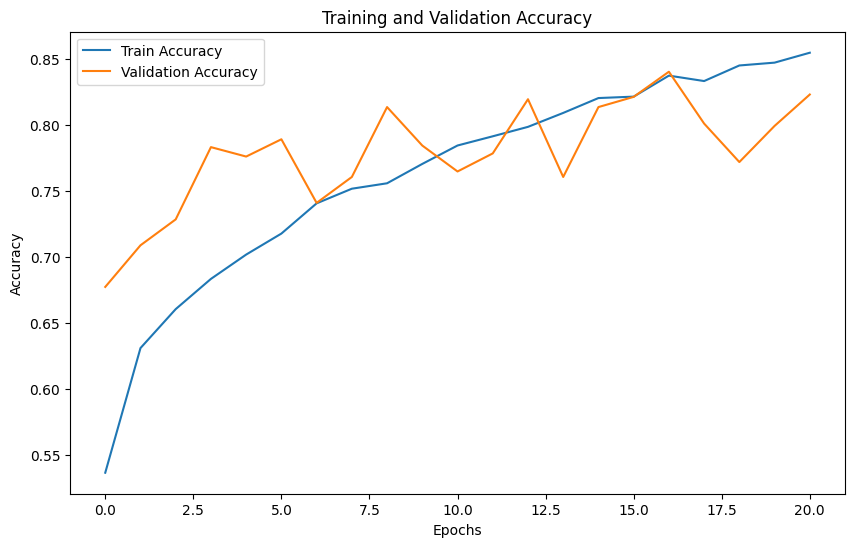

53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step


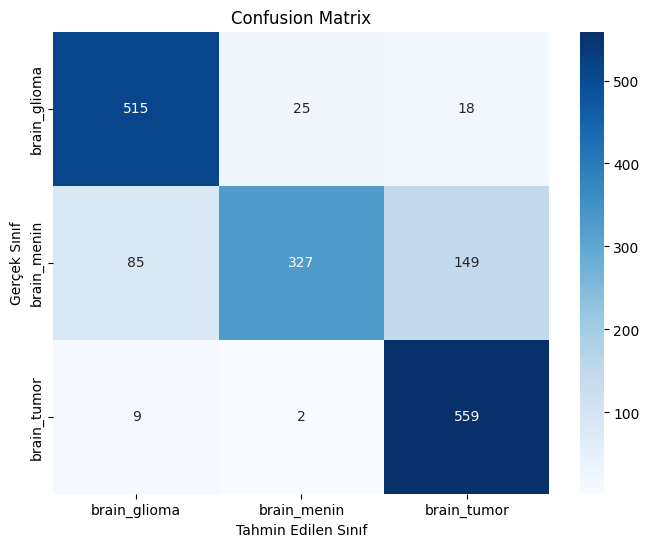

              precision    recall  f1-score   support

brain_glioma       0.85      0.92      0.88       558
 brain_menin       0.92      0.58      0.71       561
 brain_tumor       0.77      0.98      0.86       570

    accuracy                           0.83      1689
   macro avg       0.85      0.83      0.82      1689
weighted avg       0.85      0.83      0.82      1689

Model kaydedildi: brain_cancer_cnn_model.h5


In [ ]:
# Gerekli kütüphaneleri yükle
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# 1. Veri Hazırlama

# Orijinal veri yolu
original_data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'

# Çalışma dizini
base_dir = '/kaggle/working/brain_cancer_split'

# Sınıflar
classes = ['brain_glioma', 'brain_menin', 'brain_tumor']

# Klasörleri oluştur
for split in ['train', 'val', 'test']:
    for cls in classes:
        path = os.path.join(base_dir, split, cls)
        os.makedirs(path, exist_ok=True)

# Görüntüleri böl (%70 train, %15 val, %15 test)
for cls in classes:
    cls_path = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    for i, img in enumerate(images):
        if i < train_split:
            split = 'train'
        elif i < val_split:
            split = 'val'
        else:
            split = 'test'

        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, split, cls, img)
        shutil.copyfile(src, dst)

print("Veri bölme işlemi tamamlandı.")

# 2. Veri Yükleyiciler

IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 30

# Data augmentation ve preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generatorlar
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # Confusion matrix için shuffle kapalı
)

# 3. CNN Modeli Kurulumu

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Eğitme

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# 5. Performans Değerlendirme

# Test seti üzerinde doğrulama
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Set Accuracy: {test_acc:.2f}")

# Eğitim süreci görselleştirme
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 6. Confusion Matrix

# Tahminler
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix oluştur
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 7. Modeli Kaydet

model.save('/kaggle/working/brain_cancer_cnn_model.h5')
print("Model kaydedildi: brain_cancer_cnn_model.h5")


**İKİNCİ DENEME**

In [ ]:
# 📦 Gerekli Kütüphaneler
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📂 1. Veri Bölme (Train/Val/Test)
original_data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'
base_dir = '/kaggle/working/brain_cancer_split'

classes = ['brain_glioma', 'brain_menin', 'brain_tumor']

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

for cls in classes:
    cls_path = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.85 * len(images))

    for idx, img in enumerate(images):
        if idx < train_split:
            split = 'train'
        elif idx < val_split:
            split = 'val'
        else:
            split = 'test'

        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, split, cls, img)
        shutil.copyfile(src, dst)

print("Veri başarıyla bölündü.")

# 📈 2. Data Generators
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 🧠 3. CNN Modeli - İyileştirilmiş
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ⏳ 4. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1, min_lr=1e-6)

# 🚀 5. Model Eğitimi
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# 🎯 6. Test Sonucu
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Set Accuracy: {test_acc:.2%}")

# 📊 7. Eğitim/Doğrulama Grafikleri
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 🔥 8. Confusion Matrix ve Classification Report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 💾 9. Modeli Kaydet
model.save('/kaggle/working/brain_cancer_best_cnn_model.h5')
print("Model kaydedildi: brain_cancer_best_cnn_model.h5")


Veri başarıyla bölündü.
Found 5923 images belonging to 3 classes.
Found 2361 images belonging to 3 classes.
Found 2361 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 95/186 ━━━━━━━━━━━━━━━━━━━━ 10:31 7s/step - accuracy: 0.6398 - loss: 0.8421